In [2]:
import tensorflow as tf
from functions import *

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



Num GPUs Available:  1


In [3]:
import gc
gc.collect()

0

In [4]:
from tensorflow.keras.backend import clear_session
clear_session()


In [5]:
import hyperparameters as hp


directory_path = 'LA/ASVspoof2019_LA_train/flac'

In [6]:
import os
import tensorflow as tf

# add a if statement that if train_dataset.pkl exists, load it, else create it

if os.path.exists('dataset_pickle_dumps/train_dataset_dumped.pkl'):
    print("LOADING TRAIN DATASET FROM FILE")
    dataset = tf.data.experimental.load('dataset_pickle_dumps/train_dataset_dumped.pkl')
    print("TRAIN DATASET LOADED FROM FILE")
    
else:

    with open('train_preprocessed.txt', 'r') as file:
        data = file.readlines()

    file_names = []
    labels = []

    subset_size = 1000
    for line in data:
        if subset_size == 0:
            break
    #  subset_size -= 1
        file_name, label = line.split()
        file_names.append(file_name)
        labels.append(int(label))

    tensors = []

    ctr = 0 


    for file_name in file_names:
        ctr+=1
        if ctr % 200 == 0:
            print(f"PROGRESS: {ctr}/{len(file_names)}")
        file_path = os.path.join(directory_path, file_name)
        signal, sample_rate = read_flac_file(file_path)
        lfcc_features = extract_lfcc(signal, sample_rate)
        tensor = tf.convert_to_tensor(lfcc_features)
        tensor = tf.expand_dims(tensor, axis=0)
        tensors.append(tensor[0])
        
    labels = tf.convert_to_tensor(labels)

    dataset = tf.data.Dataset.from_tensor_slices((tensors, labels))

    dataset = dataset.shuffle(buffer_size=len(tensors)).batch(32)

    tf.data.experimental.save(dataset, 'dataset_pickle_dumps/train_dataset_dumped.pkl')

    print("TRAIN DATASET DUMPED TO FILE")

print("NUMBER OF ENTRIES IN TRAINING DATASET: ", len(dataset))


LOADING TRAIN DATASET FROM FILE
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
TRAIN DATASET LOADED FROM FILE
NUMBER OF ENTRIES IN TRAINING DATASET:  794


In [17]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def se_block(input_tensor, ratio=16):
#     filters = input_tensor.shape[-1]
#     se = layers.GlobalAveragePooling2D()(input_tensor)
#     se = layers.Reshape((1, 1, filters))(se)
#     se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
#     se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
#     return layers.Multiply()([input_tensor, se])

# def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
#     x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = se_block(x)
#     x = layers.Conv2D(filters, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     x = layers.BatchNormalization()(x)
#     return layers.Add()([x, input_tensor])

# def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
#     input_filters = input_tensor.shape[-1]
#     if input_filters != filters:
#         shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
#         shortcut = layers.BatchNormalization()(shortcut)
#     else:
#         shortcut = input_tensor

#     x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = se_block(x)
#     x = layers.Conv2D(filters, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     x = layers.BatchNormalization()(x)
#     return layers.Add()([x, shortcut])

# def BasicBlock(input_tensor, c_in, c_out):
#     x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     return x

# def attention_branch(input_tensor):
#     x = BasicBlock(input_tensor, 1, 2)
#     x = BasicBlock(x, 2, 4)
#     x = BasicBlock(x, 4, 8)
#     x = BasicBlock(x, 8, 16)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(16, (1, 1), padding='same')(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv2D(1, (1, 1), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     A = layers.Activation('sigmoid')(x)
#     return A

# def EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T), dropout_rate=0.2):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
#     x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
#     x = layers.Conv2D(1280, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     R = layers.GlobalAveragePooling2D()(x)
#     R_output = layers.Dense(1, activation='sigmoid')(R)
#     A = attention_branch(inputs)
#     A_adjusted = layers.GlobalAveragePooling2D()(A)
#     A_adjusted = layers.Reshape((1,))(A_adjusted)
#     combined_output = R_output + R_output * A_adjusted
#     model = models.Model(inputs, combined_output)
#     return model

# # Adding regularization 

# from keras import regularizers, losses

# eer_prev = 1

# def custom_loss(y_true, y_pred):
#     bce = losses.binary_crossentropy(y_true, y_pred)
#     reg = regularizers.l2(0.06)
#     regularization = tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)
#     loss = bce + regularization
#     return (loss * (eer_prev**2)) * 1000


# # shape: (1xFxT)
# input_shape = (1, hp.F, hp.T)
# model = EfficientNet_A0_with_attention(input_shape=input_shape)
# model.compile(optimizer='adam', loss= custom_loss, metrics=['accuracy'])
# model.summary()

import tensorflow as tf
from keras import layers, models

def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, input_tensor])

def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    input_filters = input_tensor.shape[-1]
    if input_filters != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, shortcut])

def BasicBlock(input_tensor, c_in, c_out):
    x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_branch(input_tensor):
    x = BasicBlock(input_tensor, 1, 2)
    x = BasicBlock(x, 2, 4)
    x = BasicBlock(x, 4, 8)
    x = BasicBlock(x, 8, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (1, 1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    A = layers.Activation('sigmoid')(x)
    return A

def EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
    x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = layers.Conv2D(1280, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    R = layers.GlobalAveragePooling2D()(x)
    R_output = layers.Dense(1, activation='sigmoid')(R)
    A = attention_branch(inputs)
    A_adjusted = layers.GlobalAveragePooling2D()(A)
    A_adjusted = layers.Reshape((1,))(A_adjusted)
    combined_output = R_output + R_output * A_adjusted
    model = models.Model(inputs, combined_output)
    return model

# Adding regularization 

from keras import regularizers, losses

eer_prev = 1

def custom_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    reg = regularizers.l2(0.06)
    regularization = tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)
    loss = bce + regularization
    return (loss * (eer_prev**2)) * 1000


# shape: (1xFxT)
input_shape = (1, hp.F, hp.T)
model = EfficientNet_A0_with_attention(input_shape=input_shape)
model.compile(optimizer='adam', loss= custom_loss, metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 10, 300)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_52 (Conv2D)             (None, 1, 10, 32)    9632        ['input_1[0][0]']                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 1, 10, 32)    9248        ['conv2d_52[0][0]']              
                                                                                                  
 batch_normalization_72 (BatchN  (None, 1, 10, 32)   128         ['conv2d_53[0][0]']          

In [18]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.reshape = layers.Reshape((1, 1, self.filters))
        self.conv1 = layers.Conv2D(self.filters // self.ratio, 1, activation='relu',  data_format='channels_last')
        self.conv2 = layers.Conv2D(self.filters, 1, activation='sigmoid',  data_format='channels_last')
        self.multiply = layers.Multiply()

    def call(self, inputs):
        se = layers.GlobalAveragePooling2D()(inputs)
        se = self.reshape(se)
        se = self.conv1(se)
        se = self.conv2(se)
        return self.multiply([inputs, se])


class MBConv1Block (tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, filters=16, dropout_rate=0.2):
        super(MBConv1Block, self).__init__()
        self.dconv = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same',  data_format='channels_last')
        self.swish1 = tf.keras.layers.Activation('swish')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(ratio = 16)
        self.conv = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', activation=tf.keras.activations.sigmoid,  data_format='channels_last')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        
    def call(self, input):
        output = self.dconv(input)
        output = self.batch_norm1(output)
        output = self.swish1(output)
        output = self.se(output)
        output = self.conv(output)
        output = self.batch_norm2(output)
        return output
    
class MBConv6Block (tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, filters=16, dropout_rate=0.2):
        super(MBConv6Block, self).__init__()
        self.filters = filters
        self.conv1 = tf.keras.layers.Conv2D(filters * 6, (1, 1), padding='same', activation=tf.keras.activations.relu,  data_format='channels_last')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.swish1 = tf.keras.layers.Activation('swish')
        self.dconv = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')
        self.swish2 = tf.keras.layers.Activation('swish')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(ratio = 16)
        self.conv2 = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def build(self, input_shape):
        self.input_conv = tf.keras.layers.Conv2D(self.filters, (1, 1), padding='same')
        
    def call(self, input):
        input_processed = self.input_conv(input)
        output = self.conv1(input)
        output = self.batch_norm1(output)
        output = self.swish1(output)
        output = self.dconv(output)
        output = self.swish2(output)
        output = self.batch_norm2(output)
        output = self.se(output)
        output = self.conv2(output)
        output = self.batch_norm3(output)
        output = self.dropout(output)
        output = output + input_processed
        return output

    

class BasicBlock (tf.keras.layers.Layer):
    def __init__(self,C_in,C_out):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_last')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_last')
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, input):
        input = self.conv1(input)
        input = self.bn1(input)
        input = self.conv2(input)
        input = self.bn2(input)
        return input
    

class AttentionBranch (tf.keras.Model):
    def __init__(self,):
        super(AttentionBranch, self).__init__()
        self.bb1 = BasicBlock(1,2)
        self.bb2 = BasicBlock(2,4)
        self.bb3 = BasicBlock(4,8)
        self.bb4 = BasicBlock(8,16)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', data_format='channels_last')
        self.relu = tf.keras.layers.ReLU()
        self.ab_output_conv = tf.keras.layers.Conv2D(2, (1, 1), padding='same', data_format='channels_last')
        self.ab_output_gap = tf.keras.layers.GlobalAveragePooling2D()
        self.ab_output_softmax = tf.keras.layers.Softmax()
        self.attention_map_conv = tf.keras.layers.Conv2D(1, (1, 1), padding='same', data_format='channels_last')
        self.attention_map_bn = tf.keras.layers.BatchNormalization()
        self.attention_map_sigmoid = tf.keras.layers.Activation('sigmoid')
    
    def call (self, input):
        output = self.bb1(input)
        output = self.bb2(output)
        output = self.bb3(output)
        output = self.bb4(output)
        output = self.bn1(output)
        output = self.conv1(output)
        output = self.relu(output)
        ab_output =  self.ab_output_conv(output)
        ab_output = self.ab_output_gap(ab_output)
        ab_output = self.ab_output_softmax(ab_output)
        attention_map = self.attention_map_conv(output)
        attention_map = self.attention_map_bn(attention_map)
        attention_map = self.attention_map_sigmoid(attention_map)
        return ab_output, attention_map
        
        

In [26]:
class EfficientNetA0(tf.keras.Model):
    def __init__(self, output_dim = 2, dropout=0.2):
        super(EfficientNetA0, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', data_format='channels_last')
        self.mbconv1_1 = MBConv1Block(filters = 32, dropout_rate=dropout)
        self.mbconv6_1 = MBConv6Block(filters = 32, dropout_rate=dropout)
        self.mbconv6_2 = MBConv6Block(filters = 48, dropout_rate=dropout)
        self.mbconv6_3 = MBConv6Block(filters = 48, dropout_rate=dropout)
        self.mbconv6_4 = MBConv6Block(filters = 64, dropout_rate=dropout)
        self.mbconv6_5 = MBConv6Block(filters = 64, dropout_rate=dropout)
        self.conv2 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', data_format='channels_last')
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(output_dim)
         
    def call(self, input):
        output = self.conv1(input)
        output = self.mbconv1_1(output)
        output = self.mbconv6_1(output)
        output = self.mbconv6_2(output)
        output = self.mbconv6_3(output)
        output = self.mbconv6_4(output)
        output = self.mbconv6_5(output)
        output = self.conv2(output)
        output = self.dropout(output)
        output = self.global_avg_pool(output)
        output = self.dense(output)
        return output


        

In [27]:
class EABNModel(tf.keras.Model):
    def __init__(self, dropout=0.2):
        super(EABNModel, self).__init__()
        self.efficientnet = EfficientNetA0(dropout=dropout)
        self.attention_branch = AttentionBranch()
    
    def call(self, input):
        ab_output, attention_map = self.attention_branch(input)
        perception_input = input * attention_map
        perception_input = perception_input + input
        perception_output = self.efficientnet(perception_input)
        return ab_output, perception_output

In [33]:
test_model = EABNModel()
test_model.build((None,hp.F, hp.T,1))
test_model.summary()

Model: "eabn_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficient_net_a0_11 (Effici  multiple                 280740    
 entNetA0)                                                       
                                                                 
 attention_branch_6 (Attenti  multiple                 5281      
 onBranch)                                                       
                                                                 
Total params: 286,021
Trainable params: 279,083
Non-trainable params: 6,938
_________________________________________________________________


In [26]:
'''
labels

one_ctr = 0 
zero_ctr = 0 

for i in labels : 
    if i == 0: 
        zero_ctr +=1
    else : 
        one_ctr +=1

print(one_ctr , zero_ctr)
'''

'\nlabels\n\none_ctr = 0 \nzero_ctr = 0 \n\nfor i in labels : \n    if i == 0: \n        zero_ctr +=1\n    else : \n        one_ctr +=1\n\nprint(one_ctr , zero_ctr)\n'

In [27]:
# from keras.callbacks import Callback
# from scipy.special import softmax
# import numpy as np
# from sklearn.metrics import roc_curve

# class ClassWiseAccuracy(Callback):
#     def __init__(self, dataset):
#         super().__init__()
#         self.dataset = dataset

#     def on_epoch_end(self, n_epochs_training, logs=None):
#         y_true = []
#         y_pred = []
#         for x, y in self.dataset:
#             y_true.extend(y.numpy())
#             predictions = self.model.predict(x, verbose=0)
#             if predictions.shape[1] == 1:
#                 predictions = np.hstack([1 - predictions, predictions])
#             predictions = softmax(predictions, axis=-1)
#             y_pred.extend((predictions[:, 1] > 0.5).astype(int))

#         y_true = np.array(y_true)
#         y_pred = np.array(y_pred)

#         class_0_indices = np.where(y_true == 0)
#         class_1_indices = np.where(y_true == 1)

#         class_0_accuracy = np.mean(y_true[class_0_indices] == y_pred[class_0_indices])
#         class_1_accuracy = np.mean(y_true[class_1_indices] == y_pred[class_1_indices])

#         print(f"Epoch {n_epochs_training + 1}:")
#         print(f"Accuracy for class 0 (bonafide): {class_0_accuracy}")
#         print(f"Accuracy for class 1 (spoofed): {class_1_accuracy}")

#         # print EER 
#         from sklearn.metrics import roc_curve
#         fpr, tpr, thresholds = roc_curve(y_true, y_pred)
#         eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
#         print(f"EER: {eer}")

#         if eer <= 0.04 :
#             # early stop 
#             self.model.stop_training = True 
#             return 
              

# model.fit(dataset, epochs= hp.n_epochs_training, callbacks=[ClassWiseAccuracy(dataset)])
# model.save('model.keras')


from keras.callbacks import Callback
from scipy.special import softmax
import numpy as np
from sklearn.metrics import roc_curve

class ClassWiseAccuracy(Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_scores = []  # Store raw scores for EER calculation
        for x, y in self.dataset:
            y_true.extend(y.numpy())
            predictions = self.model.predict(x, verbose=0)
            if predictions.shape[1] == 1:
                predictions = np.hstack([1 - predictions, predictions])
            predictions = softmax(predictions, axis=-1)
            y_scores.extend(predictions[:, 1])  # Use scores for the positive class

        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
        eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

        # Apply EER threshold to make final decisions
        y_pred = (y_scores > eer_threshold).astype(int)

        class_0_indices = np.where(y_true == 0)
        class_1_indices = np.where(y_true == 1)

        class_0_accuracy = np.mean(y_true[class_0_indices] == y_pred[class_0_indices])
        class_1_accuracy = np.mean(y_true[class_1_indices] == y_pred[class_1_indices])

        print(f"Epoch {epoch + 1}:")
        print(f"Accuracy for class 0 (bonafide): {class_0_accuracy}")
        print(f"Accuracy for class 1 (spoofed): {class_1_accuracy}")
        print(f"EER: {eer}")

        global eer_prev 
        eer_prev = eer

        if eer <= 0.03:
            self.model.stop_training = True

model.fit(dataset, epochs=hp.n_epochs_training, callbacks=[ClassWiseAccuracy(dataset)])
model.save('model.keras')



Epoch 1/30


2024-04-10 03:18:40.935886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


793/794 [============================>.] - ETA: 0s - loss: 960.2877 - accuracy: 0.6295Epoch 1:
Accuracy for class 0 (bonafide): 0.8864341085271318
Accuracy for class 1 (spoofed): 0.8862280701754386
EER: 0.11356589147286822
794/794 [==============================] - 43s 39ms/step - loss: 960.2493 - accuracy: 0.6295
Epoch 2/30
791/794 [============================>.] - ETA: 0s - loss: 923.6325 - accuracy: 0.8293Epoch 2:
Accuracy for class 0 (bonafide): 0.8461240310077519
Accuracy for class 1 (spoofed): 0.8471491228070176
EER: 0.15387596899224806
794/794 [==============================] - 30s 38ms/step - loss: 923.6179 - accuracy: 0.8294
Epoch 3/30
793/794 [============================>.] - ETA: 0s - loss: 913.3525 - accuracy: 0.8633Epoch 3:
Accuracy for class 0 (bonafide): 0.9321705426356589
Accuracy for class 1 (spoofed): 0.9310087719298246
EER: 0.06821705426356589
794/794 [==============================] - 31s 39ms/step - loss: 913.3143 - accuracy: 0.8634
Epoch 4/30
793/794 [==========

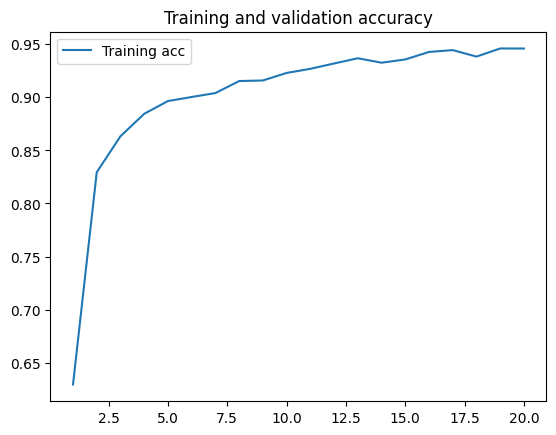

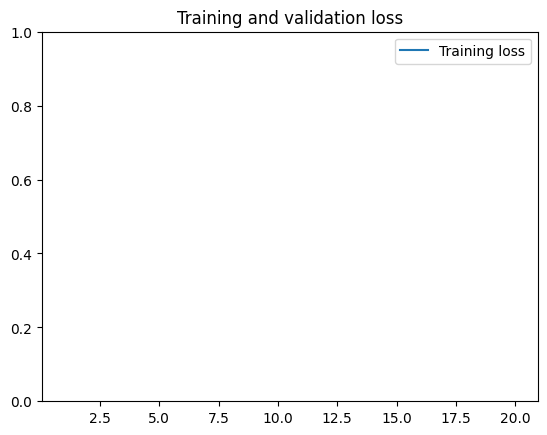

In [28]:
def plot_history(history):
    import matplotlib.pyplot as plt
    
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    # plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    # plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

plot_history(model.history)

In [29]:
# load model from pkl

# model = tf.keras.models.load_model('model.keras')


# model.evaluate(dataset_val)
# predictions = model.predict(dataset_val)

In [30]:
print("TRAINING OF THE MODEL IS DONE!")

TRAINING OF THE MODEL IS DONE!


In [31]:
#os._exit(00)